#1. Imports and adding Dependencies

In [1]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
altair                       4.2.2
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
blinker                      1.6.2
cachetools                   5.3.0
certifi                      2023.5.7
charset-normalizer           3.1.0
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
entrypoints                  0.4
executing                    1.2.0
filelock                     3.12.0
flatbuffers                  23.5.9
fonttools                    4.39.4
gast                         0.4.0
gdown                        4.7.1
gitdb                        4.0.10
GitPyth

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

#2. Get the data

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [7]:
char_to_num.get_vocabulary()
char_to_num(['a','b','h','i','s'])
num_to_char([1,  2,  8,  9, 19])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'a', b'b', b'h', b'i', b's'], dtype=object)>

In [8]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data_by_path(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments



In [9]:
test_path = '.\\data\\s1\\bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\s1\\bbal6n.mpg'>

In [10]:
frames, alignments = load_data_by_path(tf.convert_to_tensor(test_path))


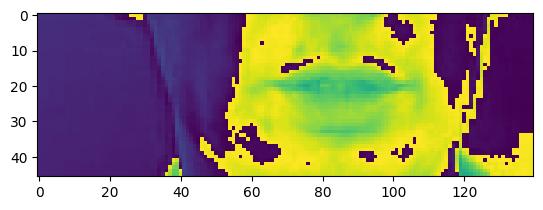

In [11]:
plt.imshow(frames[30])


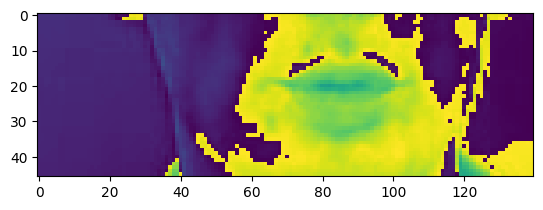

In [12]:
plt.imshow(frames[25])


In [13]:
alignments


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [14]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [15]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data_by_path, [path], (tf.float32, tf.int64))
    return result

#3. Data **Pipeline**

In [16]:
from matplotlib import pyplot as plt

In [17]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [18]:
frames, alignments = data.as_numpy_iterator().next()
alignments

array([[12,  1, 25, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 25, 39,  5,
         9,  7,  8, 20, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39,  5,
        39, 15, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [19]:
test = data.as_numpy_iterator()

In [20]:
val = test.next(); val[0]

array([[[[[ 1.3683294 ],
          [ 1.3683294 ],
          [ 1.3683294 ],
          ...,
          [ 9.282451  ],
          [ 0.14792751],
          [ 0.14792751]],

         [[ 1.3683294 ],
          [ 1.3683294 ],
          [ 1.3683294 ],
          ...,
          [ 9.282451  ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.2943656 ],
          [ 1.2943656 ],
          [ 1.2943656 ],
          ...,
          [ 0.11094563],
          [ 0.22189125],
          [ 0.22189125]],

         ...,

         [[ 0.9615288 ],
          [ 0.9615288 ],
          [ 0.9615288 ],
          ...,
          [ 0.        ],
          [ 9.430379  ],
          [ 9.430379  ]],

         [[ 0.9615288 ],
          [ 0.9615288 ],
          [ 0.9615288 ],
          ...,
          [ 0.        ],
          [ 9.430379  ],
          [ 9.430379  ]],

         [[ 0.9615288 ],
          [ 0.9615288 ],
          [ 0.9615288 ],
          ...,
          [ 0.        ],
          [ 9.430379  ],
          

In [21]:
import imageio
import numpy as np

converted_array = (val[0][1] * 255).astype(np.uint8)
grayscale_array = np.squeeze(converted_array)

imageio.mimsave('animation.gif', grayscale_array, duration=100)

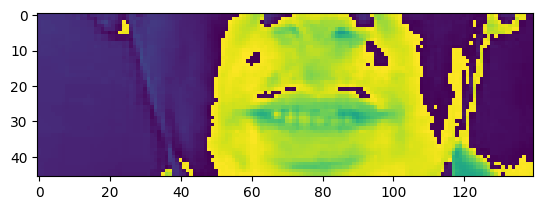

In [22]:
plt.imshow(val[0][0][15])

In [23]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white at r seven soon'>

# Desiging the Neural Net

In [24]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [25]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [26]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [28]:
yhat = model.predict(val[0])

1/1 [==============================] - 10s 10s/step


In [29]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr'>

In [30]:
model.input_shape


(None, 75, 46, 140, 1)

In [31]:
model.output_shape


(None, 75, 41)

# Setting up Learning

In [32]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [33]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [34]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [35]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [36]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [37]:
schedule_callback = LearningRateScheduler(scheduler)


In [38]:
example_callback = ProduceExample(data)      


In [39]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 12s 12s/step- loss: 85.6050
Original: set green by c seven soon
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in i two please
Prediction: le e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 36946s 82s/step - loss: 85.6050 - val_loss: 70.2444 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 8s 8s/step
Original: set red with v one soon
Prediction: le e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with r five soon
Prediction: le e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 31643s 70s/step - loss: 71.8346 - lr: 1.0000e-04
Epoch 3/1

#Predicitng and testing with dataset


In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

#Testing on Data

In [ ]:
sample =load_data_by_path(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]